<a href="https://colab.research.google.com/github/parkyw2/parkyw2/blob/main/%EA%B8%B0%EC%9E%AC%ED%92%88_%EC%86%8C%EB%AA%A8%ED%92%88%EB%B9%84_%EA%B3%B5%EC%9E%A5%EB%B3%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext rpy2.ipython
%matplotlib inline
from fbprophet import Prophet
import pandas as pd
from matplotlib import pyplot as plt
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/My\ Drive/회사 데이터

/content/drive/My Drive/회사 데이터


In [13]:
df = pd.read_csv('소모품비_기재품_plant.csv')

In [14]:
df.tail(10)

,date,1110,1120,1130,1140,1150,1160,1170,1180,total
1086,2021-12-22,4193400,1400600,0,2224040,12058740,1691700,466210,1445400,23480090
1087,2021-12-23,10788600,1317958,0,1878800,462870,0,1211400,78000,15737628
1088,2021-12-24,0,136300,0,567400,0,2484400,557320,0,3745420
1089,2021-12-25,0,0,0,0,0,0,0,0,0
1090,2021-12-26,0,0,0,0,0,0,0,0,0
1091,2021-12-27,10026356,3562000,0,2223180,0,4850900,3431300,2737980,26831716
1092,2021-12-28,3716000,0,0,0,0,5757400,1325800,774900,11574100
1093,2021-12-29,145800,0,0,387100,0,6234849,336700,583300,7687749
1094,2021-12-30,388360,835300,0,3468040,10233600,9261860,570800,0,24757960
1095,2021-12-31,0,651600,0,183400,-205956,3487730,491100,0,4607874


In [15]:
#안양
df_1110 = df[['date','1110']]

In [16]:
df_1110.tail(10)

,date,1110
1086,2021-12-22,4193400
1087,2021-12-23,10788600
1088,2021-12-24,0
1089,2021-12-25,0
1090,2021-12-26,0
1091,2021-12-27,10026356
1092,2021-12-28,3716000
1093,2021-12-29,145800
1094,2021-12-30,388360
1095,2021-12-31,0


In [17]:
df_1110['ds'] = pd.to_datetime(df['date'])
df_1110['y'] = df_1110['1110']
df_1110 = df_1110.loc[:,['ds', 'y']]
df_1110.head()

In [22]:
df_1110['ds'] = pd.to_datetime(df_1110['ds'])
df_1110 = df_1110[df_1110['ds'].dt.dayofweek < 5]
df_1110['date_index'] = df_1110['ds']
df_1110 = df_1110.set_index('date_index')
df_1110['cap'] = 30000000
df_1110['floor'] = 0
df_1110.head(10)

In [28]:
df_1110.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 784 entries, 2019-01-01 to 2021-12-31
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      784 non-null    datetime64[ns]
 1   y       784 non-null    int64         
 2   cap     784 non-null    int64         
 3   floor   784 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 30.6 KB


In [29]:
from datetime import datetime
df_1110 = df_1110[datetime(2019, 1, 1):datetime(2021, 12, 22)]

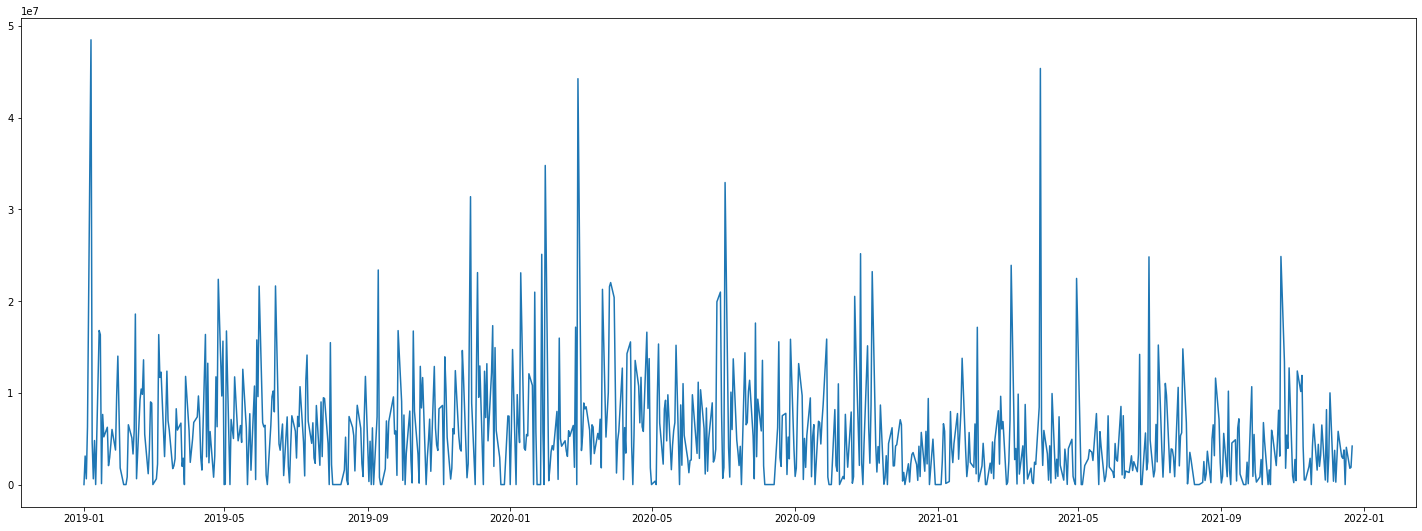

In [31]:
plt.figure(figsize = (25, 9))
plt.plot(df_1110.index,df_1110.y)
plt.show()

In [32]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1110)

future = m.make_future_dataframe(periods=9)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 30000000
future['floor'] = 0

future.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [35]:
forecast=m.predict(future)
preds= forecast['yhat'][:-7]

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Children's Day,Alternative holiday of Children's Day_lower,Alternative holiday of Children's Day_upper,Alternative holiday of Lunar New Year's Day,Alternative holiday of Lunar New Year's Day_lower,Alternative holiday of Lunar New Year's Day_upper,Alternative public holiday,Alternative public holiday_lower,Alternative public holiday_upper,Birthday of the Buddha,Birthday of the Buddha_lower,Birthday of the Buddha_upper,Children's Day,Children's Day_lower,Children's Day_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Chuseok,Chuseok_lower,Chuseok_upper,Hangeul Day,Hangeul Day_lower,Hangeul Day_upper,Independence Movement Day,Independence Movement Day_lower,Independence Movement Day_upper,Labour Day,Labour Day_lower,Labour Day_upper,Liberation Day,Liberation Day_lower,...,Memorial Day,Memorial Day_lower,Memorial Day_upper,National Foundation Day,National Foundation Day_lower,National Foundation Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,The day preceding of Chuseok,The day preceding of Chuseok_lower,The day preceding of Chuseok_upper,The day preceding of Lunar New Year's Day,The day preceding of Lunar New Year's Day_lower,The day preceding of Lunar New Year's Day_upper,The second day of Chuseok,The second day of Chuseok_lower,The second day of Chuseok_upper,The second day of Lunar New Year's Day,The second day of Lunar New Year's Day_lower,The second day of Lunar New Year's Day_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
774,2021-12-20,70827.684324,30000000,0,-2.898278e+06,1.140081e+07,70827.684324,70827.684324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.189482e+06,4.189482e+06,4.189482e+06,0.0,0.0,0.0,-8.698697e+05,-8.698697e+05,-8.698697e+05,5.510173e+06,5.510173e+06,5.510173e+06,-450821.490954,-450821.490954,-450821.490954,0.0,0.0,0.0,4.260309e+06
775,2021-12-21,71033.957955,30000000,0,-4.031423e+06,1.059173e+07,71033.957955,71033.957955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.433217e+06,3.433217e+06,3.433217e+06,0.0,0.0,0.0,-7.234426e+05,-7.234426e+05,-7.234426e+05,4.584945e+06,4.584945e+06,4.584945e+06,-428285.177154,-428285.177154,-428285.177154,0.0,0.0,0.0,3.504251e+06
776,2021-12-22,71240.830893,30000000,0,-2.634810e+06,1.184686e+07,71240.830893,71240.830893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.526273e+06,4.526273e+06,4.526273e+06,0.0,0.0,0.0,-4.792474e+05,-4.792474e+05,-4.792474e+05,5.409090e+06,5.409090e+06,5.409090e+06,-403569.732717,-403569.732717,-403569.732717,0.0,0.0,0.0,4.597513e+06
777,2021-12-23,71448.304871,30000000,0,-1.823807e+06,1.210043e+07,71448.304871,71448.304871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.971629e+06,4.971629e+06,4.971629e+06,0.0,0.0,0.0,-1.522983e+05,-1.522983e+05,-1.522983e+05,5.500634e+06,5.500634e+06,5.500634e+06,-376706.933987,-376706.933987,-376706.933987,0.0,0.0,0.0,5.043077e+06
778,2021-12-24,71656.381627,30000000,0,1.008748e+06,1.527636e+07,71656.381627,71656.381627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

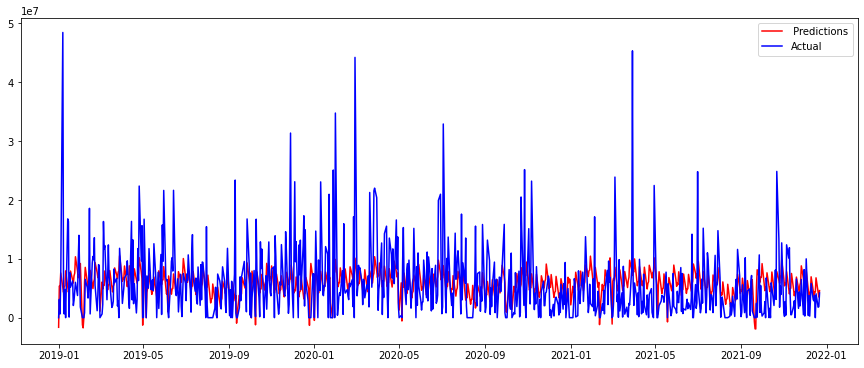

In [38]:
plt.figure(figsize=(15,6))
plt.plot(df_1110.index,preds,color='red',label=' Predictions')
plt.plot(df_1110.index,df_1110.y,color='blue',label='Actual')
plt.legend()
plt.show()

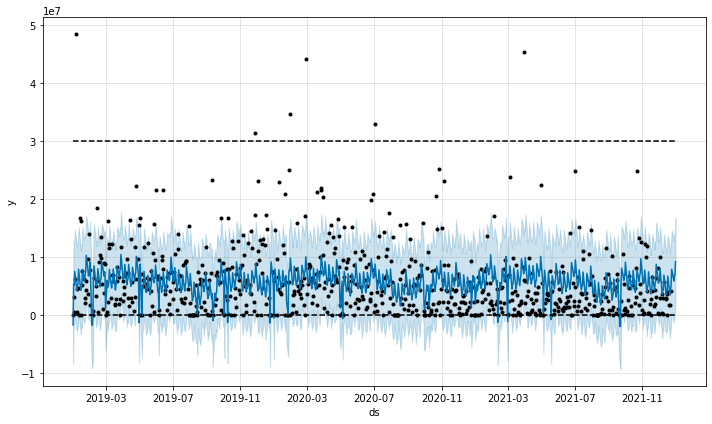

In [39]:
fig = m.plot(m.predict(future))

In [41]:
r2 = round(r2_score(df_1110["y"], preds), 3)
mse = round(mean_squared_error(df_1110["y"], preds), 3)
mae = round(mean_absolute_error(df_1110["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.111
MSE:  31318539590336.895
MAE:  3929033.653


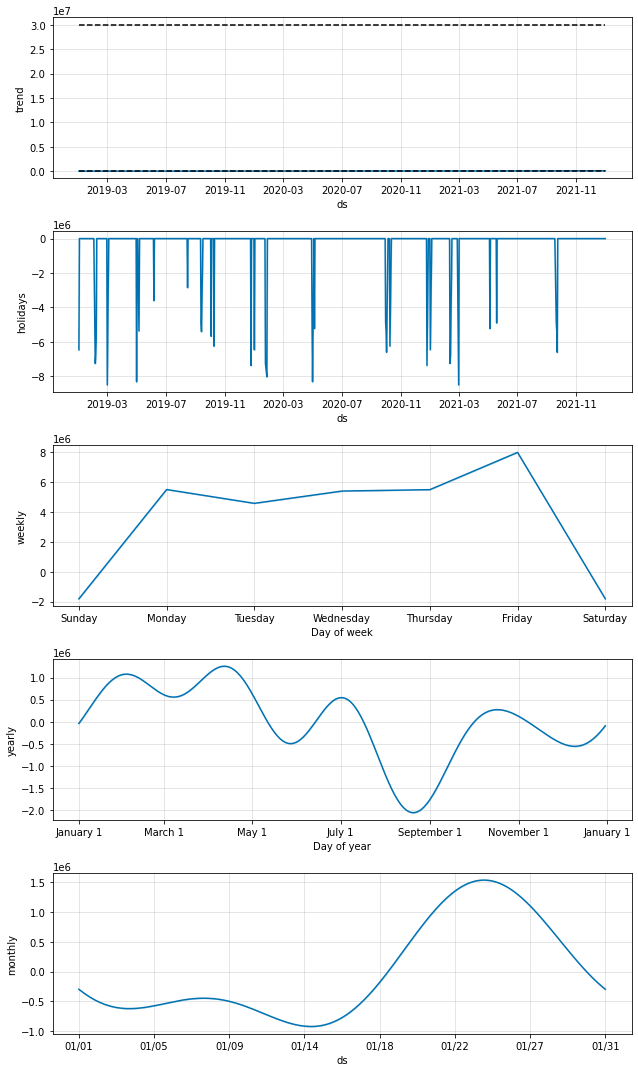

In [42]:
fig = m.plot_components(forecast)

In [43]:
forecast.tail()

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Children's Day,Alternative holiday of Children's Day_lower,Alternative holiday of Children's Day_upper,Alternative holiday of Lunar New Year's Day,Alternative holiday of Lunar New Year's Day_lower,Alternative holiday of Lunar New Year's Day_upper,Alternative public holiday,Alternative public holiday_lower,Alternative public holiday_upper,Birthday of the Buddha,Birthday of the Buddha_lower,Birthday of the Buddha_upper,Children's Day,Children's Day_lower,Children's Day_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Chuseok,Chuseok_lower,Chuseok_upper,Hangeul Day,Hangeul Day_lower,Hangeul Day_upper,Independence Movement Day,Independence Movement Day_lower,Independence Movement Day_upper,Labour Day,Labour Day_lower,Labour Day_upper,Liberation Day,Liberation Day_lower,...,Memorial Day,Memorial Day_lower,Memorial Day_upper,National Foundation Day,National Foundation Day_lower,National Foundation Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,The day preceding of Chuseok,The day preceding of Chuseok_lower,The day preceding of Chuseok_upper,The day preceding of Lunar New Year's Day,The day preceding of Lunar New Year's Day_lower,The day preceding of Lunar New Year's Day_upper,The second day of Chuseok,The second day of Chuseok_lower,The second day of Chuseok_upper,The second day of Lunar New Year's Day,The second day of Lunar New Year's Day_lower,The second day of Lunar New Year's Day_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
779,2021-12-27,72284.246015,30000000,0,-3.565516e+05,1.405084e+07,72284.246015,72284.246015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.545986e+06,6.545986e+06,6.545986e+06,0.0,0.0,0.0,1.284612e+06,1.284612e+06,1.284612e+06,5.510173e+06,5.510173e+06,5.510173e+06,-248798.295335,-248798.295335,-248798.295335,0.0,0.0,0.0,6.618270e+06
780,2021-12-28,72494.751360,30000000,0,-9.715243e+05,1.312201e+07,72494.751360,72494.751360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.846681e+06,5.846681e+06,5.846681e+06,0.0,0.0,0.0,1.473793e+06,1.473793e+06,1.473793e+06,4.584945e+06,4.584945e+06,4.584945e+06,-212056.692876,-212056.692876,-212056.692876,0.0,0.0,0.0,5.919176e+06
781,2021-12-29,72705.868247,30000000,0,-3.926302e+05,1.481125e+07,72705.868247,72705.868247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.771786e+06,6.771786e+06,6.771786e+06,0.0,0.0,0.0,1.536284e+06,1.536284e+06,1.536284e+06,5.409090e+06,5.409090e+06,5.409090e+06,-173587.312730,-173587.312730,-173587.312730,0.0,0.0,0.0,6.844492e+06
782,2021-12-30,72917.598444,30000000,0,-4.024354e+05,1.370819e+07,72917.598444,72917.598444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.834210e+06,6.834210e+06,6.834210e+06,0.0,0.0,0.0,1.467073e+06,1.467073e+06,1.467073e+06,5.500634e+06,5.500634e+06,5.500634e+06,-133497.685225,-133497.685225,-133497.685225,0.0,0.0,0.0,6.907127e+06
783,2021-12-31,73129.943724,30000000,0,1.585294e+06,1.616362e+07,73129.943723,73129.943724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

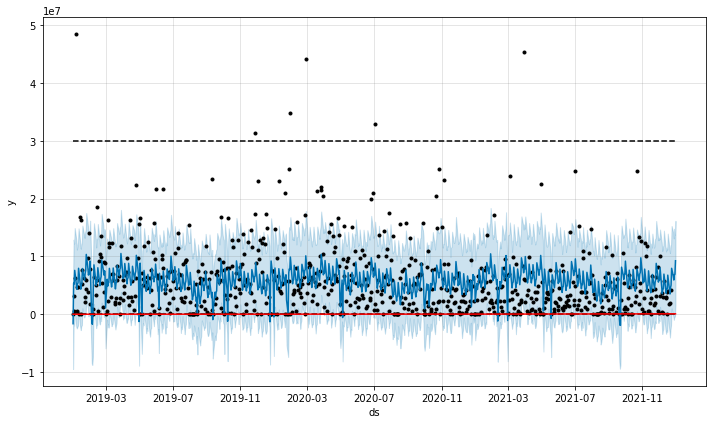

In [44]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [45]:
  pd.options.display.float_format = '{:,.0f}'.format

In [46]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(9))

            ds      yhat  yhat_lower  yhat_upper
775 2021-12-21 3,504,251  -4,031,423  10,591,726
776 2021-12-22 4,597,513  -2,634,810  11,846,862
777 2021-12-23 5,043,077  -1,823,807  12,100,428
778 2021-12-24 7,951,139   1,008,748  15,276,365
779 2021-12-27 6,618,270    -356,552  14,050,844
780 2021-12-28 5,919,176    -971,524  13,122,013
781 2021-12-29 6,844,492    -392,630  14,811,255
782 2021-12-30 6,907,127    -402,435  13,708,195
783 2021-12-31 9,257,905   1,585,294  16,163,620


In [51]:
final_1110 = forecast[['ds', 'yhat']]
final_1110['yhat_1110'] = final_1110['yhat']
final_1110 = final_1110[['ds', 'yhat_1110']]

In [52]:
final_1110.tail()

,ds,yhat_1110
0,2019-01-01,"-1,638,232"
1,2019-01-02,"5,370,695"
2,2019-01-03,"5,237,673"
3,2019-01-04,"7,591,302"
4,2019-01-07,"5,139,840"


In [55]:
#Ansung
df_1120 = df[['date','1120']]
df_1120['ds'] = pd.to_datetime(df_1120['date'])
df_1120['y'] = df_1120['1120']
df_1120 = df_1120.loc[:,['ds', 'y']]
df_1120.head()

,ds,y
0,2019-01-01,0
1,2019-01-02,459470
2,2019-01-03,921500
3,2019-01-04,256950
4,2019-01-05,0


In [56]:
df_1120['ds'] = pd.to_datetime(df_1120['ds'])
df_1120 = df_1120[df_1120['ds'].dt.dayofweek < 5]
df_1120['date_index'] = df_1120['ds']
df_1120 = df_1120.set_index('date_index')
df_1120['cap'] = 30000000
df_1120['floor'] = 0
df_1120.head(10)

,ds,y,cap,floor
date_index,,,,
2019-01-01,2019-01-01,0,30000000,0
2019-01-02,2019-01-02,459470,30000000,0
2019-01-03,2019-01-03,921500,30000000,0
2019-01-04,2019-01-04,256950,30000000,0
2019-01-07,2019-01-07,0,30000000,0
2019-01-08,2019-01-08,59080,30000000,0
2019-01-09,2019-01-09,247650,30000000,0
2019-01-10,2019-01-10,196300,30000000,0
2019-01-11,2019-01-11,1889730,30000000,0


In [58]:
from datetime import datetime
df_1120 = df_1120[datetime(2019, 1, 1):datetime(2021, 12, 22)]

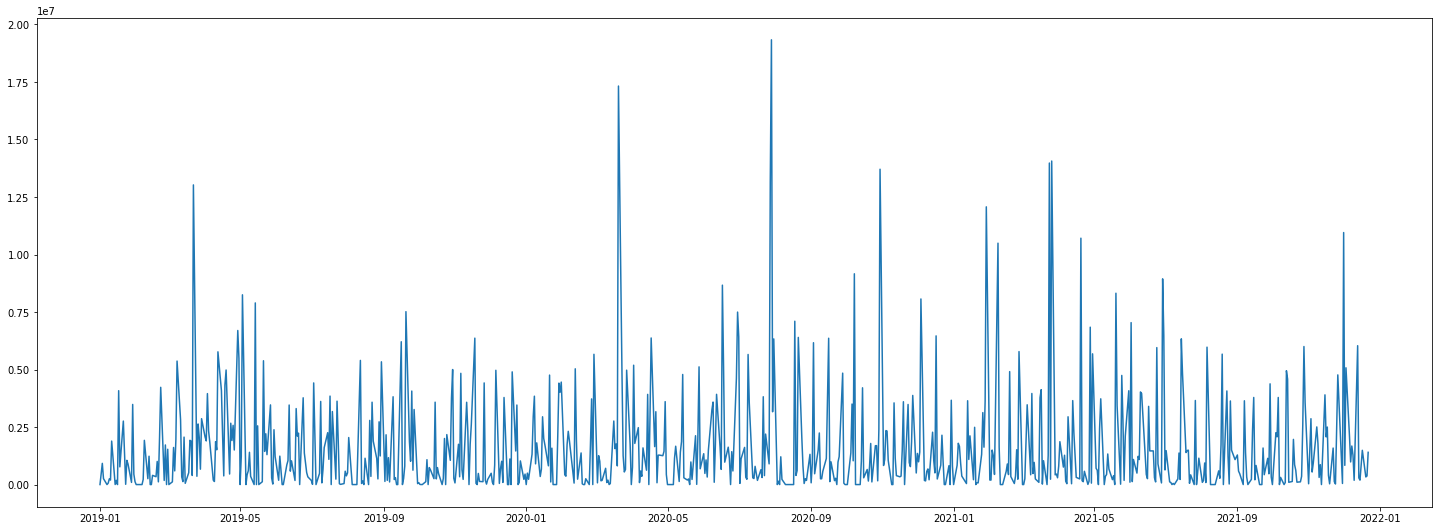

In [59]:
plt.figure(figsize = (25, 9))
plt.plot(df_1120.index,df_1120.y)
plt.show()

In [60]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1120)

future = m.make_future_dataframe(periods=9)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 30000000
future['floor'] = 0

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,cap,floor
781,2021-12-27,30000000,0
782,2021-12-28,30000000,0
783,2021-12-29,30000000,0
784,2021-12-30,30000000,0
785,2021-12-31,30000000,0


In [61]:
forecast=m.predict(future)
forecast.tail(10)

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Children's Day,Alternative holiday of Children's Day_lower,Alternative holiday of Children's Day_upper,Alternative holiday of Lunar New Year's Day,Alternative holiday of Lunar New Year's Day_lower,Alternative holiday of Lunar New Year's Day_upper,Alternative public holiday,Alternative public holiday_lower,Alternative public holiday_upper,Birthday of the Buddha,Birthday of the Buddha_lower,Birthday of the Buddha_upper,Children's Day,Children's Day_lower,Children's Day_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Chuseok,Chuseok_lower,Chuseok_upper,Hangeul Day,Hangeul Day_lower,Hangeul Day_upper,Independence Movement Day,Independence Movement Day_lower,Independence Movement Day_upper,Labour Day,Labour Day_lower,Labour Day_upper,Liberation Day,Liberation Day_lower,...,Memorial Day,Memorial Day_lower,Memorial Day_upper,National Foundation Day,National Foundation Day_lower,National Foundation Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,The day preceding of Chuseok,The day preceding of Chuseok_lower,The day preceding of Chuseok_upper,The day preceding of Lunar New Year's Day,The day preceding of Lunar New Year's Day_lower,The day preceding of Lunar New Year's Day_upper,The second day of Chuseok,The second day of Chuseok_lower,The second day of Chuseok_upper,The second day of Lunar New Year's Day,The second day of Lunar New Year's Day_lower,The second day of Lunar New Year's Day_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
774,2021-12-20,"463,834",30000000,0,"-1,653,477","4,065,427","463,834","463,834",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"686,707","686,707","686,707",0,0,0,"11,955","11,955","11,955","1,017,405","1,017,405","1,017,405","-342,652","-342,652","-342,652",0,0,0,"1,150,542"
775,2021-12-21,"464,619",30000000,0,"-1,274,062","4,330,250","464,619","464,619",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"1,048,448","1,048,448","1,048,448",0,0,0,"-18,784","-18,784","-18,784","1,410,972","1,410,972","1,410,972","-343,739","-343,739","-343,739",0,0,0,"1,513,067"
776,2021-12-22,"465,405",30000000,0,"-1,266,986","4,656,090","465,405","465,405",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"1,191,115","1,191,115","1,191,115",0,0,0,"-26,182","-26,182","-26,182","1,561,105","1,561,105","1,561,105","-343,807","-343,807","-343,807",0,0,0,"1,656,520"
777,2021-12-23,"466,192",30000000,0,"-1,510,018","4,510,505","466,192","466,192",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"1,046,147","1,046,147","1,046,147",0,0,0,-584,-584,-584,"1,389,600","1,389,600","1,389,600","-342,869","-342,869","-342,869",0,0,0,"1,512,339"
778,2021-12-24,"466,980",30000000,0,"-636,815","5,149,699","466,980","466,980",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"1,667,693","1,667,693","1,667,693",0,0,0,"60,934","60,934","60,934","1,947,703","1,947,703","1,947,703","-340,945","-340,945","-340,945",0,0,0,"2,134,673"
779,2021-12-27,"469,354",30000000,0,"-1,326,905","4,408,414","469,354","469,354",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"1,069,609","1,069,609","1,069,609",0,0,0,"381,766","381,766","381,766","1,017,405","1,017,405","1,017,405","-329,562","-329,562","-329,562",0,0,0,"1,538,963"
780,2021-12-28,"470,148",30000000,0,"-914,900","4,892,198","470,148","470,148",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

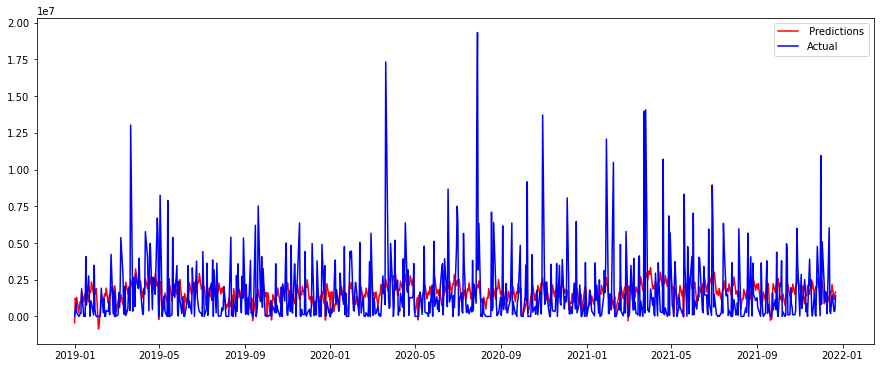

In [63]:
preds= forecast['yhat'][:-7]
plt.figure(figsize=(15,6))
plt.plot(df_1120.index,preds,color='red',label=' Predictions')
plt.plot(df_1120.index,df_1120.y,color='blue',label='Actual')
plt.legend()
plt.show()

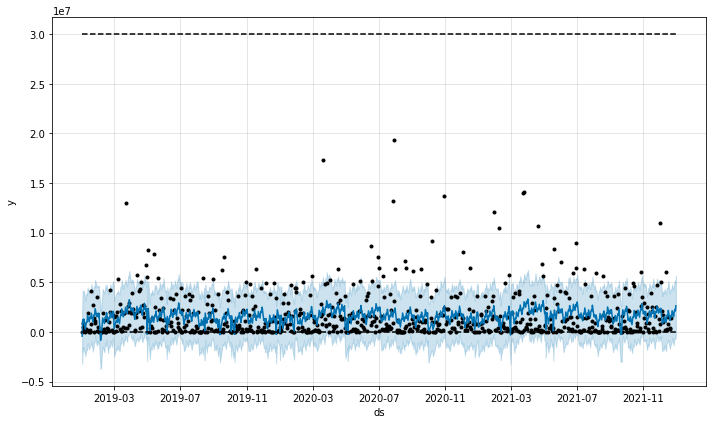

In [64]:
fig = m.plot(m.predict(future))

In [65]:
r2 = round(r2_score(df_1120["y"], preds), 3)
mse = round(mean_squared_error(df_1120["y"], preds), 3)
mae = round(mean_absolute_error(df_1120["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.074
MSE:  4852562791625.474
MAE:  1481383.574


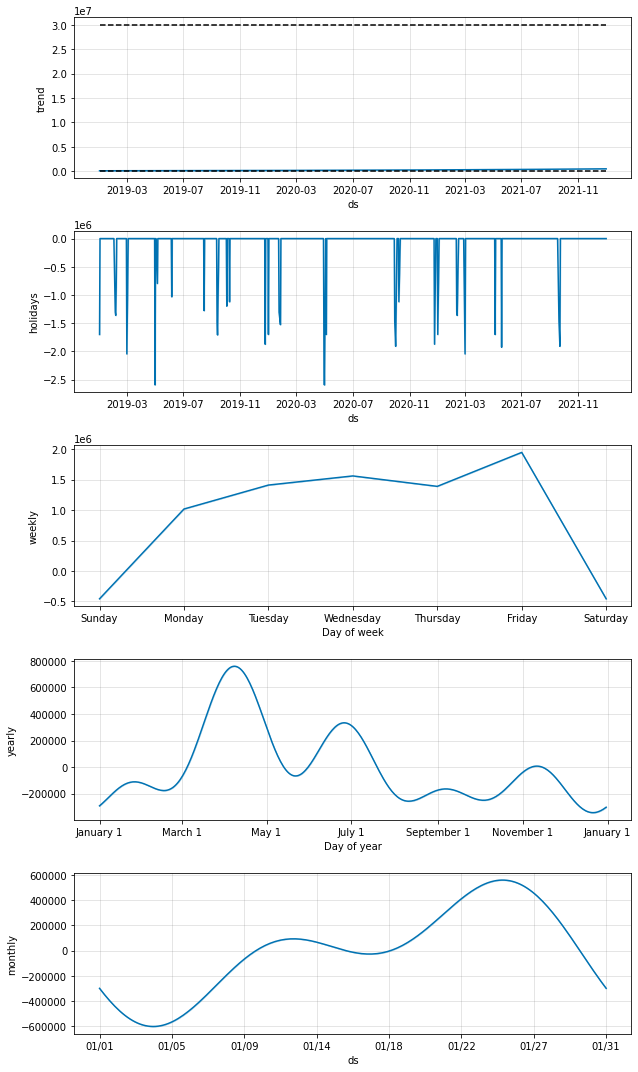

In [66]:
fig = m.plot_components(forecast)

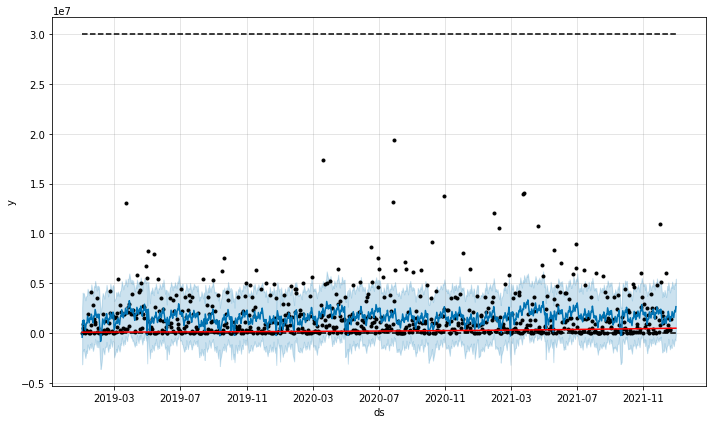

In [67]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [68]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(9))

            ds      yhat  yhat_lower  yhat_upper
775 2021-12-21 1,513,067  -1,274,062   4,330,250
776 2021-12-22 1,656,520  -1,266,986   4,656,090
777 2021-12-23 1,512,339  -1,510,018   4,510,505
778 2021-12-24 2,134,673    -636,815   5,149,699
779 2021-12-27 1,538,963  -1,326,905   4,408,414
780 2021-12-28 2,037,878    -914,900   4,892,198
781 2021-12-29 2,259,151    -602,736   4,995,518
782 2021-12-30 2,109,879    -763,746   4,838,634
783 2021-12-31 2,633,156     -64,297   5,450,607


In [70]:
final_1120 = forecast[['ds', 'yhat']]
final_1120['yhat_1120'] = final_1120['yhat']
final_1120 = final_1120[['ds', 'yhat_1120']]
final_1120.tail()

,ds,yhat_1120
779,2021-12-27,"1,538,963"
780,2021-12-28,"2,037,878"
781,2021-12-29,"2,259,151"
782,2021-12-30,"2,109,879"
783,2021-12-31,"2,633,156"


In [78]:
#Asan
df_1140 = df[['date','1140']]
df_1140['ds'] = pd.to_datetime(df_1140['date'])
df_1140['y'] = df_1140['1140']
df_1140 = df_1140.loc[:,['ds', 'y']]
df_1140.head()

,ds,y
0,2019-01-01,0
1,2019-01-02,463200
2,2019-01-03,1708000
3,2019-01-04,272500
4,2019-01-05,0


In [79]:
df_1140['ds'] = pd.to_datetime(df_1140['ds'])
df_1140 = df_1140[df_1140['ds'].dt.dayofweek < 5]
df_1140['date_index'] = df_1140['ds']
df_1140 = df_1140.set_index('date_index')
df_1140['cap'] = 30000000
df_1140['floor'] = 0
df_1140.head(10)

,ds,y,cap,floor
date_index,,,,
2019-01-01,2019-01-01,0,30000000,0
2019-01-02,2019-01-02,463200,30000000,0
2019-01-03,2019-01-03,1708000,30000000,0
2019-01-04,2019-01-04,272500,30000000,0
2019-01-07,2019-01-07,0,30000000,0
2019-01-08,2019-01-08,3764000,30000000,0
2019-01-09,2019-01-09,2679690,30000000,0
2019-01-10,2019-01-10,3392000,30000000,0
2019-01-11,2019-01-11,485000,30000000,0


In [80]:
from datetime import datetime
df_1140 = df_1140[datetime(2019, 1, 1):datetime(2021, 12, 22)]

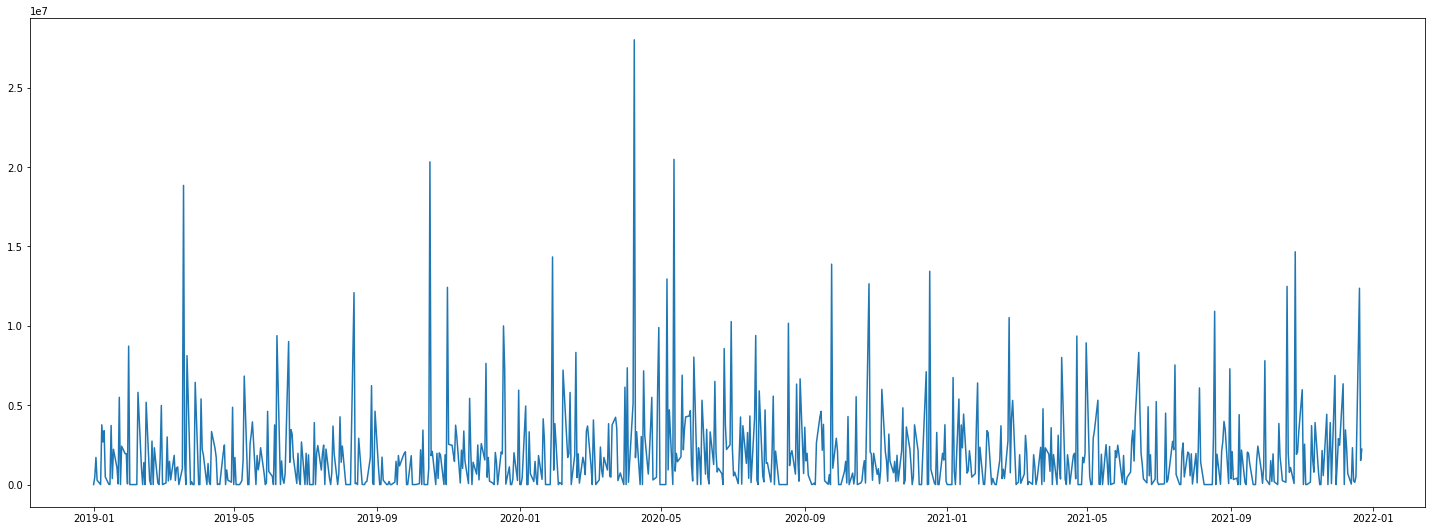

In [81]:
plt.figure(figsize = (25, 9))
plt.plot(df_1140.index,df_1140.y)
plt.show()

In [82]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1140)

future = m.make_future_dataframe(periods=9)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 30000000
future['floor'] = 0

forecast=m.predict(future)
forecast.tail(10)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Children's Day,Alternative holiday of Children's Day_lower,Alternative holiday of Children's Day_upper,Alternative holiday of Lunar New Year's Day,Alternative holiday of Lunar New Year's Day_lower,Alternative holiday of Lunar New Year's Day_upper,Alternative public holiday,Alternative public holiday_lower,Alternative public holiday_upper,Birthday of the Buddha,Birthday of the Buddha_lower,Birthday of the Buddha_upper,Children's Day,Children's Day_lower,Children's Day_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Chuseok,Chuseok_lower,Chuseok_upper,Hangeul Day,Hangeul Day_lower,Hangeul Day_upper,Independence Movement Day,Independence Movement Day_lower,Independence Movement Day_upper,Labour Day,Labour Day_lower,Labour Day_upper,Liberation Day,Liberation Day_lower,...,Memorial Day,Memorial Day_lower,Memorial Day_upper,National Foundation Day,National Foundation Day_lower,National Foundation Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,The day preceding of Chuseok,The day preceding of Chuseok_lower,The day preceding of Chuseok_upper,The day preceding of Lunar New Year's Day,The day preceding of Lunar New Year's Day_lower,The day preceding of Lunar New Year's Day_upper,The second day of Chuseok,The second day of Chuseok_lower,The second day of Chuseok_upper,The second day of Lunar New Year's Day,The second day of Lunar New Year's Day_lower,The second day of Lunar New Year's Day_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
774,2021-12-20,"276,581",30000000,0,"-2,115,132","5,035,438","276,581","276,581",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"1,308,162","1,308,162","1,308,162",0,0,0,"130,839","130,839","130,839","1,332,536","1,332,536","1,332,536","-155,213","-155,213","-155,213",0,0,0,"1,584,743"
775,2021-12-21,"277,190",30000000,0,"-1,167,120","6,208,271","277,190","277,190",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"2,336,398","2,336,398","2,336,398",0,0,0,"109,559","109,559","109,559","2,372,609","2,372,609","2,372,609","-145,770","-145,770","-145,770",0,0,0,"2,613,588"
776,2021-12-22,"277,800",30000000,0,"-1,043,927","5,898,565","277,800","277,800",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"2,012,790","2,012,790","2,012,790",0,0,0,"92,171","92,171","92,171","2,056,300","2,056,300","2,056,300","-135,682","-135,682","-135,682",0,0,0,"2,290,590"
777,2021-12-23,"278,412",30000000,0,"-1,346,795","5,839,079","278,412","278,412",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"1,879,336","1,879,336","1,879,336",0,0,0,"84,104","84,104","84,104","1,920,247","1,920,247","1,920,247","-125,015","-125,015","-125,015",0,0,0,"2,157,748"
778,2021-12-24,"279,025",30000000,0,"-1,069,925","5,714,516","279,025","279,025",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"1,838,403","1,838,403","1,838,403",0,0,0,"88,178","88,178","88,178","1,864,062","1,864,062","1,864,062","-113,837","-113,837","-113,837",0,0,0,"2,117,428"
779,2021-12-27,"280,872",30000000,0,"-1,983,789","5,119,987","280,872","280,872",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"1,409,723","1,409,723","1,409,723",0,0,0,"155,148","155,148","155,148","1,332,536","1,332,536","1,332,536","-77,960","-77,960","-77,960",0,0,0,"1,690,595"
780,2021-12-28,"281,491",30000000,0,"-839,734","6,363,433","281,491","281,491",0,0,0,0,0,0,0,0,0,0,0,0,0,0

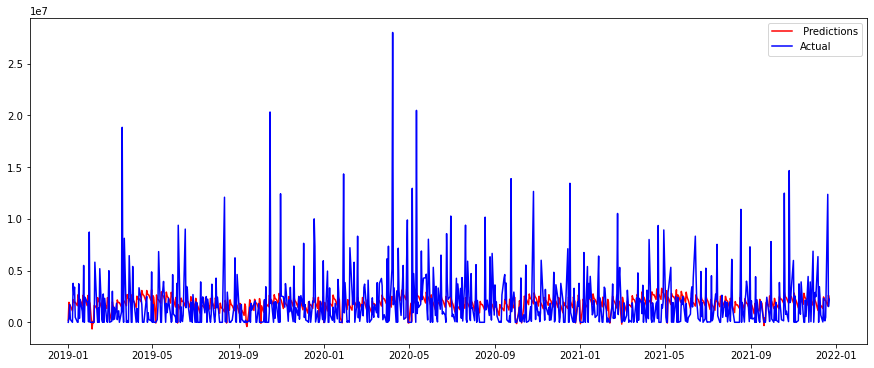

In [83]:
preds= forecast['yhat'][:-7]
plt.figure(figsize=(15,6))
plt.plot(df_1140.index,preds,color='red',label=' Predictions')
plt.plot(df_1140.index,df_1140.y,color='blue',label='Actual')
plt.legend()
plt.show()

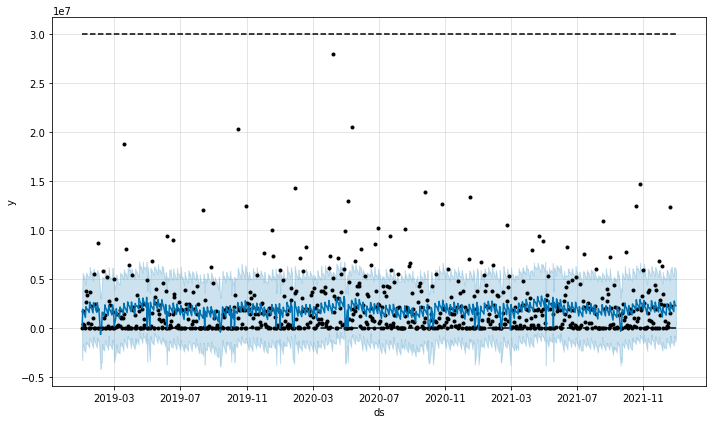

In [84]:
fig = m.plot(m.predict(future))

In [85]:
r2 = round(r2_score(df_1140["y"], preds), 3)
mse = round(mean_squared_error(df_1140["y"], preds), 3)
mae = round(mean_absolute_error(df_1140["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.047
MSE:  7709584093064.349
MAE:  1775247.317


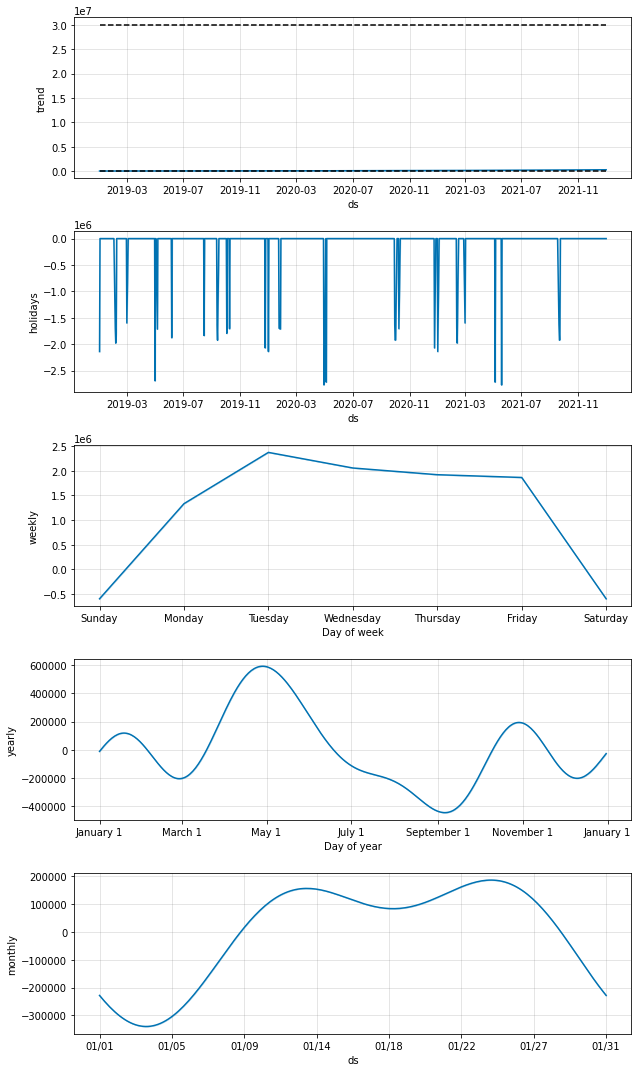

In [86]:
fig = m.plot_components(forecast)

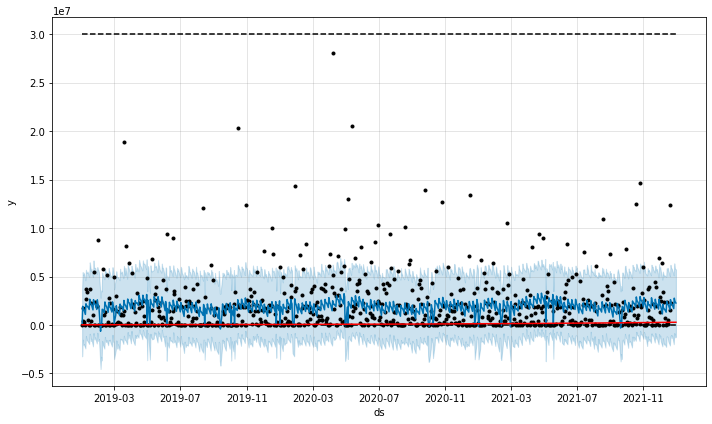

In [87]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [88]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(9))

            ds      yhat  yhat_lower  yhat_upper
775 2021-12-21 2,613,588  -1,167,120   6,208,271
776 2021-12-22 2,290,590  -1,043,927   5,898,565
777 2021-12-23 2,157,748  -1,346,795   5,839,079
778 2021-12-24 2,117,428  -1,069,925   5,714,516
779 2021-12-27 1,690,595  -1,983,789   5,119,987
780 2021-12-28 2,765,683    -839,734   6,363,433
781 2021-12-29 2,472,232  -1,018,696   5,869,209
782 2021-12-30 2,340,699  -1,289,995   5,770,058
783 2021-12-31 2,267,053  -1,181,211   5,745,705


In [89]:
final_1140 = forecast[['ds', 'yhat']]
final_1140['yhat_1140'] = final_1140['yhat']
final_1140 = final_1140[['ds', 'yhat_1140']]
final_1140.head()

,ds,yhat_1140
0,2019-01-01,"177,235"
1,2019-01-02,"1,927,525"
2,2019-01-03,"1,723,832"
3,2019-01-04,"1,616,441"
4,2019-01-07,"1,091,092"


In [90]:
#Poseung
df_1150 = df[['date','1150']]
df_1150['ds'] = pd.to_datetime(df_1150['date'])
df_1150['y'] = df_1150['1150']
df_1150 = df_1150.loc[:,['ds', 'y']]
df_1150.head()

,ds,y
0,2019-01-01,0
1,2019-01-02,0
2,2019-01-03,0
3,2019-01-04,0
4,2019-01-05,0


In [91]:
df_1150['ds'] = pd.to_datetime(df_1150['ds'])
df_1150 = df_1150[df_1150['ds'].dt.dayofweek < 5]
df_1150['date_index'] = df_1150['ds']
df_1150 = df_1150.set_index('date_index')
df_1150['cap'] = 30000000
df_1150['floor'] = 0
df_1150.head(10)

,ds,y,cap,floor
date_index,,,,
2019-01-01,2019-01-01,0,30000000,0
2019-01-02,2019-01-02,0,30000000,0
2019-01-03,2019-01-03,0,30000000,0
2019-01-04,2019-01-04,0,30000000,0
2019-01-07,2019-01-07,0,30000000,0
2019-01-08,2019-01-08,0,30000000,0
2019-01-09,2019-01-09,0,30000000,0
2019-01-10,2019-01-10,0,30000000,0
2019-01-11,2019-01-11,0,30000000,0


In [92]:
from datetime import datetime
df_1150 = df_1150[datetime(2019, 1, 1):datetime(2021, 12, 22)]

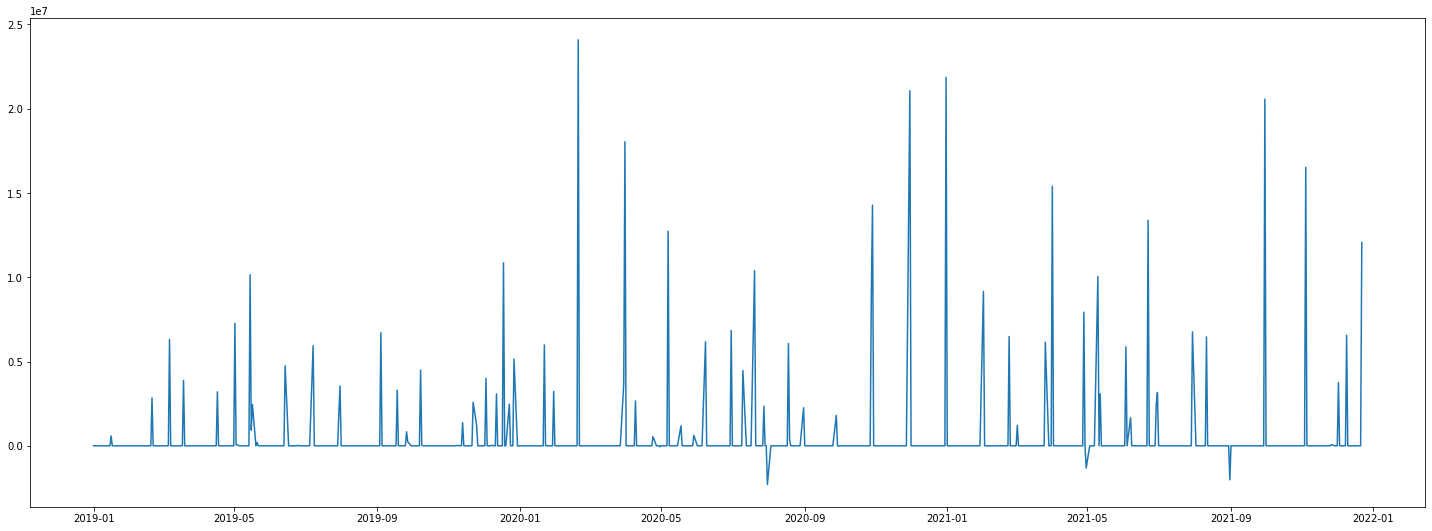

In [93]:
plt.figure(figsize = (25, 9))
plt.plot(df_1150.index,df_1150.y)
plt.show()

In [95]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1150)

future = m.make_future_dataframe(periods=9)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 30000000
future['floor'] = 0

forecast=m.predict(future)
forecast.tail(10)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Children's Day,Alternative holiday of Children's Day_lower,Alternative holiday of Children's Day_upper,Alternative holiday of Lunar New Year's Day,Alternative holiday of Lunar New Year's Day_lower,Alternative holiday of Lunar New Year's Day_upper,Alternative public holiday,Alternative public holiday_lower,Alternative public holiday_upper,Birthday of the Buddha,Birthday of the Buddha_lower,Birthday of the Buddha_upper,Children's Day,Children's Day_lower,Children's Day_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Chuseok,Chuseok_lower,Chuseok_upper,Hangeul Day,Hangeul Day_lower,Hangeul Day_upper,Independence Movement Day,Independence Movement Day_lower,Independence Movement Day_upper,Labour Day,Labour Day_lower,Labour Day_upper,Liberation Day,Liberation Day_lower,...,Memorial Day,Memorial Day_lower,Memorial Day_upper,National Foundation Day,National Foundation Day_lower,National Foundation Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,The day preceding of Chuseok,The day preceding of Chuseok_lower,The day preceding of Chuseok_upper,The day preceding of Lunar New Year's Day,The day preceding of Lunar New Year's Day_lower,The day preceding of Lunar New Year's Day_upper,The second day of Chuseok,The second day of Chuseok_lower,The second day of Chuseok_upper,The second day of Lunar New Year's Day,The second day of Lunar New Year's Day_lower,The second day of Lunar New Year's Day_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
774,2021-12-20,"419,005",30000000,0,"-1,872,155","4,226,351","419,005","419,005",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"778,634","778,634","778,634",0,0,0,"-99,976","-99,976","-99,976","427,358","427,358","427,358","451,252","451,252","451,252",0,0,0,"1,197,639"
775,2021-12-21,"420,626",30000000,0,"-1,960,644","4,221,718","420,626","420,626",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"692,988","692,988","692,988",0,0,0,"-119,303","-119,303","-119,303","366,020","366,020","366,020","446,270","446,270","446,270",0,0,0,"1,113,614"
776,2021-12-22,"422,253",30000000,0,"-1,686,994","4,194,861","422,253","422,253",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"831,280","831,280","831,280",0,0,0,"-138,071","-138,071","-138,071","529,784","529,784","529,784","439,567","439,567","439,567",0,0,0,"1,253,533"
777,2021-12-23,"423,887",30000000,0,"-1,338,157","4,943,987","423,887","423,887",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"1,302,931","1,302,931","1,302,931",0,0,0,"-143,643","-143,643","-143,643","1,015,390","1,015,390","1,015,390","431,183","431,183","431,183",0,0,0,"1,726,818"
778,2021-12-24,"425,526",30000000,0,"-2,059,413","4,129,755","425,526","425,526",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"435,969","435,969","435,969",0,0,0,"-125,174","-125,174","-125,174","139,970","139,970","139,970","421,172","421,172","421,172",0,0,0,"861,495"
779,2021-12-27,"430,483",30000000,0,"-1,858,022","4,400,508","430,483","430,483",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"923,560","923,560","923,560",0,0,0,"114,167","114,167","114,167","427,358","427,358","427,358","382,035","382,035","382,035",0,0,0,"1,354,043"
780,2021-12-28,"432,148",30000000,0,"-1,879,521","4,597,488","432,148","432,148",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0

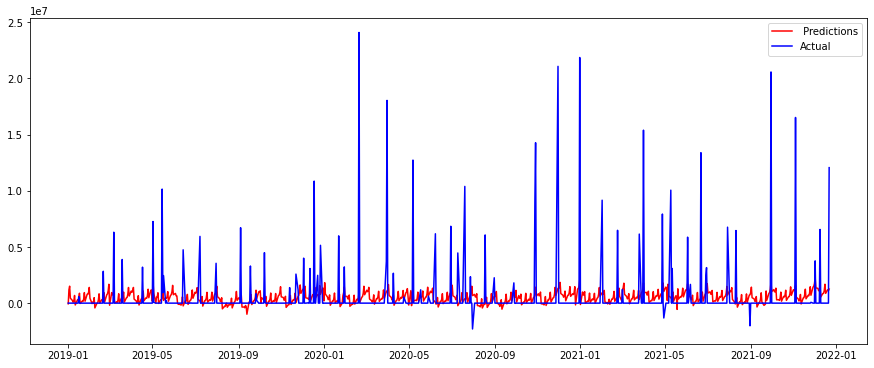

In [96]:
preds= forecast['yhat'][:-7]
plt.figure(figsize=(15,6))
plt.plot(df_1150.index,preds,color='red',label=' Predictions')
plt.plot(df_1150.index,df_1150.y,color='blue',label='Actual')
plt.legend()
plt.show()

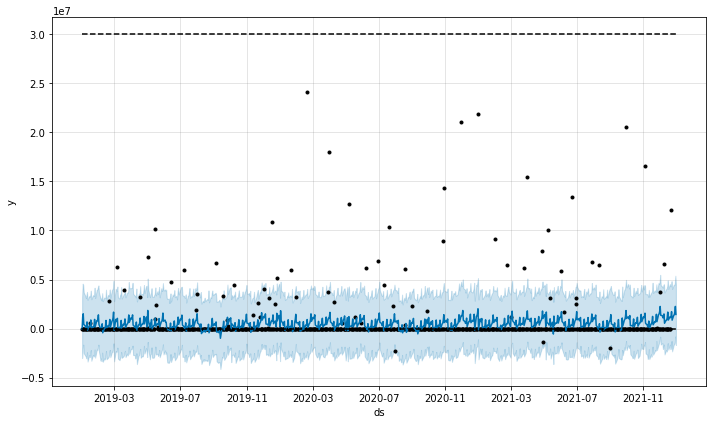

In [97]:
fig = m.plot(m.predict(future))

In [98]:
r2 = round(r2_score(df_1150["y"], preds), 3)
mse = round(mean_squared_error(df_1150["y"], preds), 3)
mae = round(mean_absolute_error(df_1150["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.039
MSE:  5867857153605.623
MAE:  1034590.024


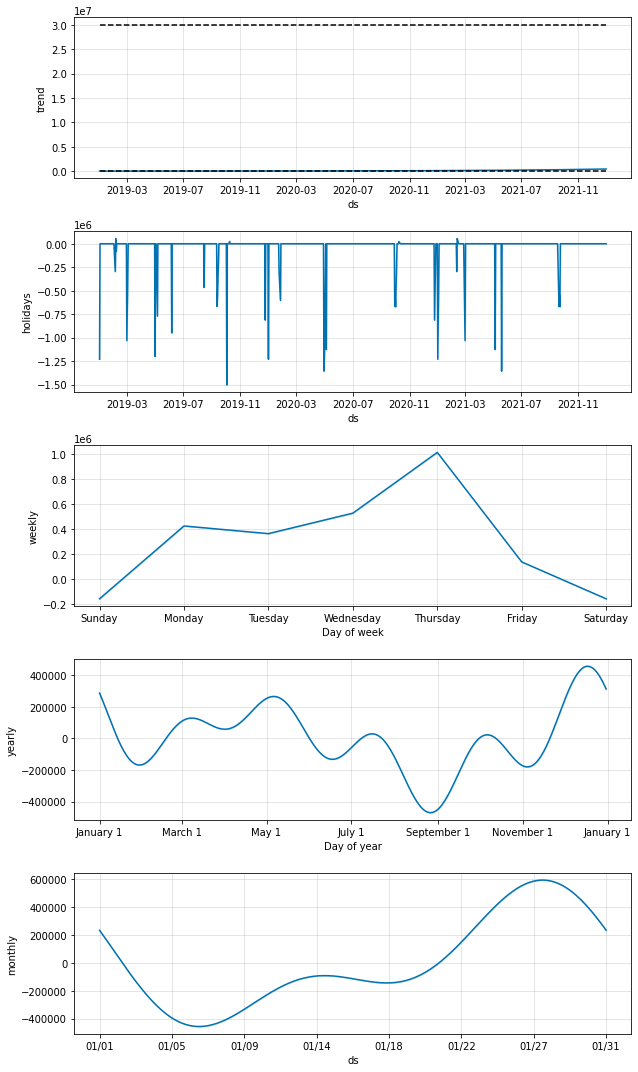

In [99]:
fig = m.plot_components(forecast)

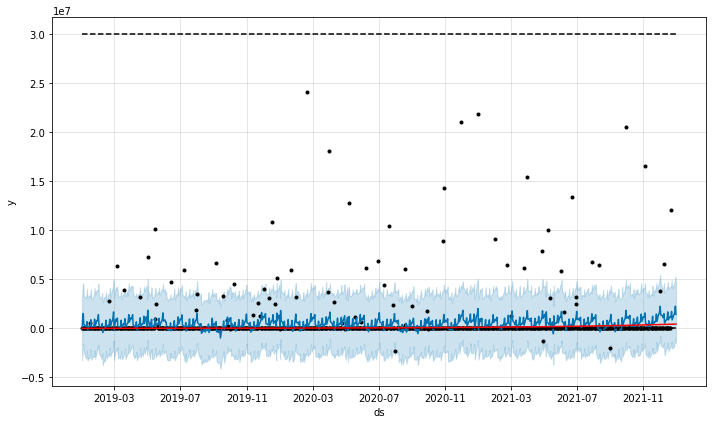

In [100]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [101]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(9))

            ds      yhat  yhat_lower  yhat_upper
775 2021-12-21 1,113,614  -1,960,644   4,221,718
776 2021-12-22 1,253,533  -1,686,994   4,194,861
777 2021-12-23 1,726,818  -1,338,157   4,943,987
778 2021-12-24   861,495  -2,059,413   4,129,755
779 2021-12-27 1,354,043  -1,858,022   4,400,508
780 2021-12-28 1,403,590  -1,879,521   4,597,488
781 2021-12-29 1,678,524  -1,342,725   4,823,930
782 2021-12-30 2,258,735  -1,069,500   5,245,742
783 2021-12-31 1,445,156  -1,508,609   4,674,200


In [102]:
final_1150 = forecast[['ds', 'yhat']]
final_1150['yhat_1150'] = final_1150['yhat']
final_1150 = final_1150[['ds', 'yhat_1150']]
final_1150.head()

,ds,yhat_1150
0,2019-01-01,"-58,202"
1,2019-01-02,"1,196,388"
2,2019-01-03,"1,508,621"
3,2019-01-04,"442,019"
4,2019-01-07,"233,540"
